# Business Analytics Project Managment Capstone Project

### Goal: Develop an ad serving algorithm using marketing data from an online grocery store.

The project uses marketing data uploaded to Kaggle [here](https://www.kaggle.com/jackdaoud/marketing-data) by Jack Daoud. The data consists of reactions from 2,240 customers of an online grocery store to 5 different ads/promotions. Customer's reactions to the ads are recorded as 1 if the desired action is taken (acceptance) or 0 otherwise. The data set also has demographic information (age, family size, income, location) and shopping history (days since last purchase, number of purchases made with discount, amount spent in last 2 years on fruit, mean, wine, sweets). 

The basic (hypothetical) problem is: suppose we are advertising online through the business shopping portal, which of the 5 ads should we show a customer to maximize the rate of acceptance?

We use the marketing data to train binary classification machine learning models that predict the probability a customer accepts each individual ad among the 5. Then we show the customer the ad that he/she is most likely to accept based on the model predictions.

We experimented with 3 different machine learning models: logistic regression, naive Bayes and random forest. In each case the models' ad recommendations **significantly outperformed the best individual ad, nearly doubling the acceptance rate** on a hold-out sample.  Among the 3 model alternatives, we found that **random forest was consistently most accurate in predicting individual ad acceptance and produced the highest acceptance rate**. 


Data exploration and visualization libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Style settings

In [2]:
sns.set_style('darkgrid')
bar_color = 'cornflowerblue'

## Exploratory Data Analysis

Import data

In [3]:
df = pd.read_csv('marketing_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

### Data Dictionary
- *ID*: unique customer identification key
- *Year_Birth*: year of customer's birth
- *Education*: customer's level of education
- *Marital_Status*: customer's marital status
- *Income*: customer's yearly household income
- *Kidhome*: number of small children in customer's home
- *Teenhome*: number of teenagers in customer's household
- *Dt_Customer*: date of customer's enrollment with the company
- *Recency*: number of days since last purchase
- *MntWines*: amount spent on wines in the last 2 years
- *MntFruits*: amount spent on fruits in the last 2 years
- *MntMeatProducts*: amount spent on meat products in the last 2 years
- *MntFishProducts*: amount spent on fish products in the last 2 years
- *MntSweenProducts*: amount spent on sweet products in the last 2 years
- *MntGoldProds*: amount spent on gold in the last 2 years
- *NumDealsPurchases*: number of purchases made with discount
- *NumWebPurchases*:  number of purchases made through company's website
- *NumCatalogPurchases*: number of purchases made through catalogue
- *NumStorePurchases*: number of purchases made directly in stores
- *NumWebVisitsMonth*: number of visits to company's web site in the last month
- *AcceptedCmp_n*: 1 if customer accepted the offer in the n^th campaign, 0 otherwise
- *Response*: 1 if customer accepted the offer in the last campaign, 0 otherwise
- *Complain*: 1 if customer complained in last 2 years, 0 otherwise
- *Country*: abbreviation for customer's country

In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,"$84,835.00",0,0,6/16/14,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,"$57,091.00",0,0,6/15/14,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,"$67,267.00",0,1,5/13/14,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,"$32,474.00",1,1,5/11/14,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,"$21,474.00",1,0,4/8/14,0,6,...,2,7,1,0,0,0,0,1,0,SP


### Functions for making distribution plots
Before transforming the data at all we make quick plots of the distribution using bar and pie charts.

In [6]:
def plot_counts(col, data, color=None):
    """Make a bar chart counting the items in column col."""
    if color is None:
        color = bar_color
    sns.countplot(x=col, data=data, color=color)
    plt.title('Customer Count by ' + col)
    

def makePieChart(df, title, legend_outside=False):
    """Plot a pie chart from a Dataframe with one column."""
    labels = list(df.index)
    vals = list(df[df.columns[0]])
    fig, ax = plt.subplots(figsize=(7.5,5))
    ax.set_prop_cycle('color', [plt.get_cmap('Blues')(1. * i / len(labels)) for i in range(len(labels))])
    
    if legend_outside:
        patches, texts = ax.pie(vals, 
                                shadow=True, 
                                startangle=90 
                                )
        
        legend_vals = [100.0*v / sum(vals) for v in vals]
        legend_labels = ['{0} - {1:1.0f}%'.format(i, v) for (i, v) in zip(labels, legend_vals)]
        ax.legend(patches, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 14})
        
    else:
        patches, texts, autotexts = ax.pie(vals, 
                                        labels=labels, 
                                        autopct='%1.0f%%', 
                                        shadow=True, 
                                        startangle=90, 
                                        textprops={'fontsize': 14}
                                       )
    
    ax.set_title(title, fontsize=16)
    ax.axis('equal')
    plt.tight_layout()
    plt.show()
    return


def pieChartBreakdown(df, byCol, legend_outside=False, title=None):
    """Group by byCol and make a pie chart."""
    data = df.groupby([byCol]).sum()
    if title is None:
        title = byCol
    
    makePieChart(data, title, legend_outside)
    return

Text(0.5, 1.0, 'Histogram of Customer Birth Year')

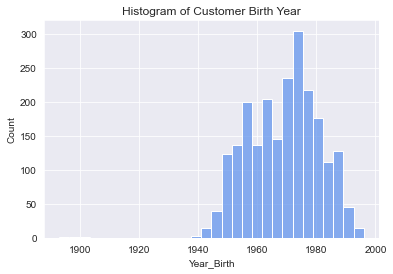

In [7]:
sns.histplot(df['Year_Birth'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Customer Birth Year')

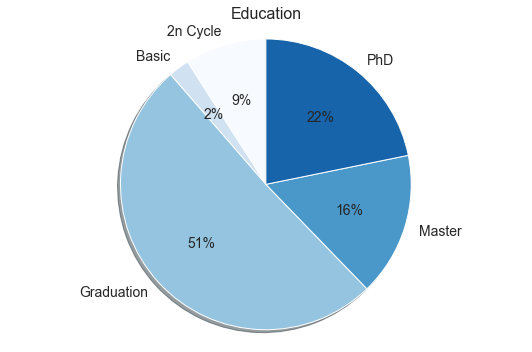

In [8]:
pieChartBreakdown(df, 'Education')

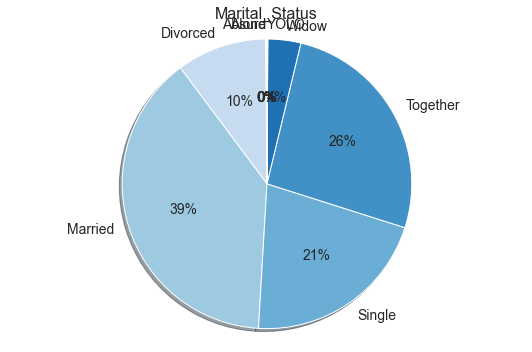

In [9]:
pieChartBreakdown(df, 'Marital_Status')

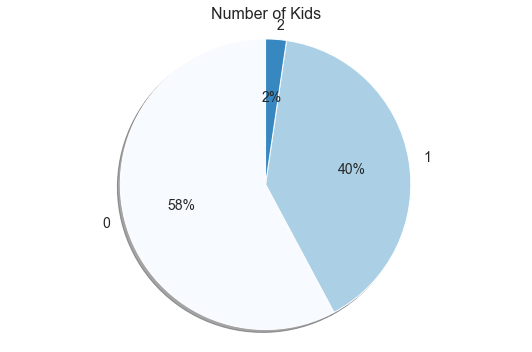

In [10]:
pieChartBreakdown(df, 'Kidhome', title='Number of Kids')

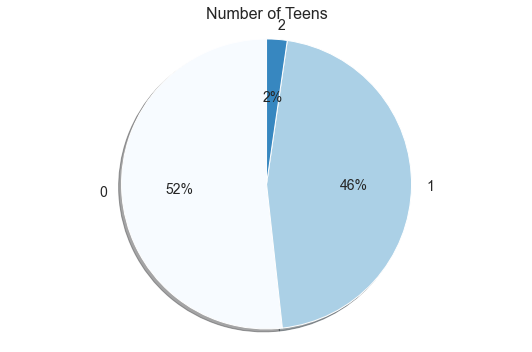

In [11]:
pieChartBreakdown(df, 'Teenhome', title='Number of Teens')

Text(0.5, 1.0, 'Histogram of Days Since Last Purchase')

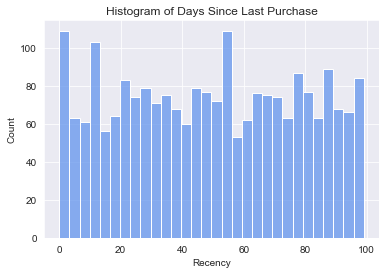

In [12]:
sns.histplot(df['Recency'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Days Since Last Purchase')

Text(0.5, 1.0, 'Histogram of Amount Spent on Wines in Last 2 Years')

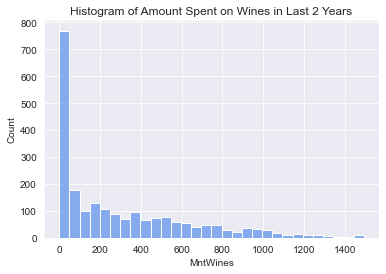

In [13]:
sns.histplot(df['MntWines'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Amount Spent on Wines in Last 2 Years')

Text(0.5, 1.0, 'Histogram of Amount Spent on Fruit in Last 2 Years')

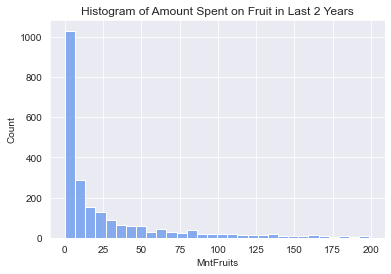

In [14]:
sns.histplot(df['MntFruits'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Amount Spent on Fruit in Last 2 Years')

Text(0.5, 1.0, 'Histogram of Amount Spent on Meat in Last 2 Years')

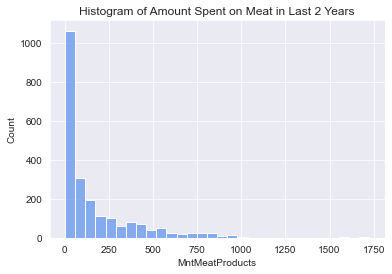

In [15]:
sns.histplot(df['MntMeatProducts'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Amount Spent on Meat in Last 2 Years')

Text(0.5, 1.0, 'Histogram of Amount Spent on Fish in Last 2 Years')

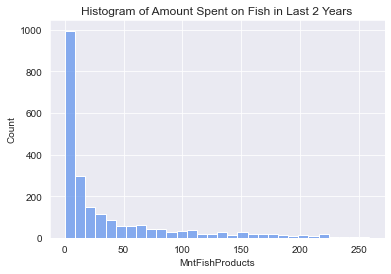

In [16]:
sns.histplot(df['MntFishProducts'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Amount Spent on Fish in Last 2 Years')

Text(0.5, 1.0, 'Histogram of Amount Spent on Sweets in Last 2 Years')

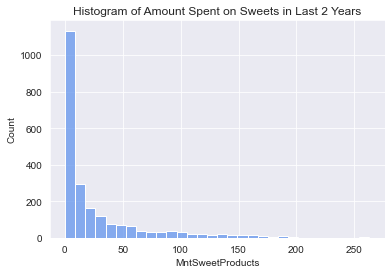

In [17]:
sns.histplot(df['MntSweetProducts'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Amount Spent on Sweets in Last 2 Years')

Text(0.5, 1.0, 'Histogram of Amount Spent on Gold Products in Last 2 Years')

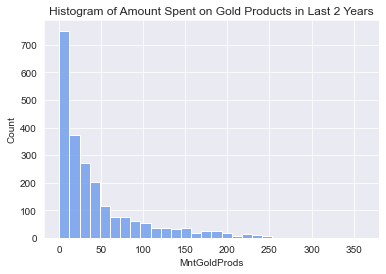

In [18]:
sns.histplot(df['MntGoldProds'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Amount Spent on Gold Products in Last 2 Years')

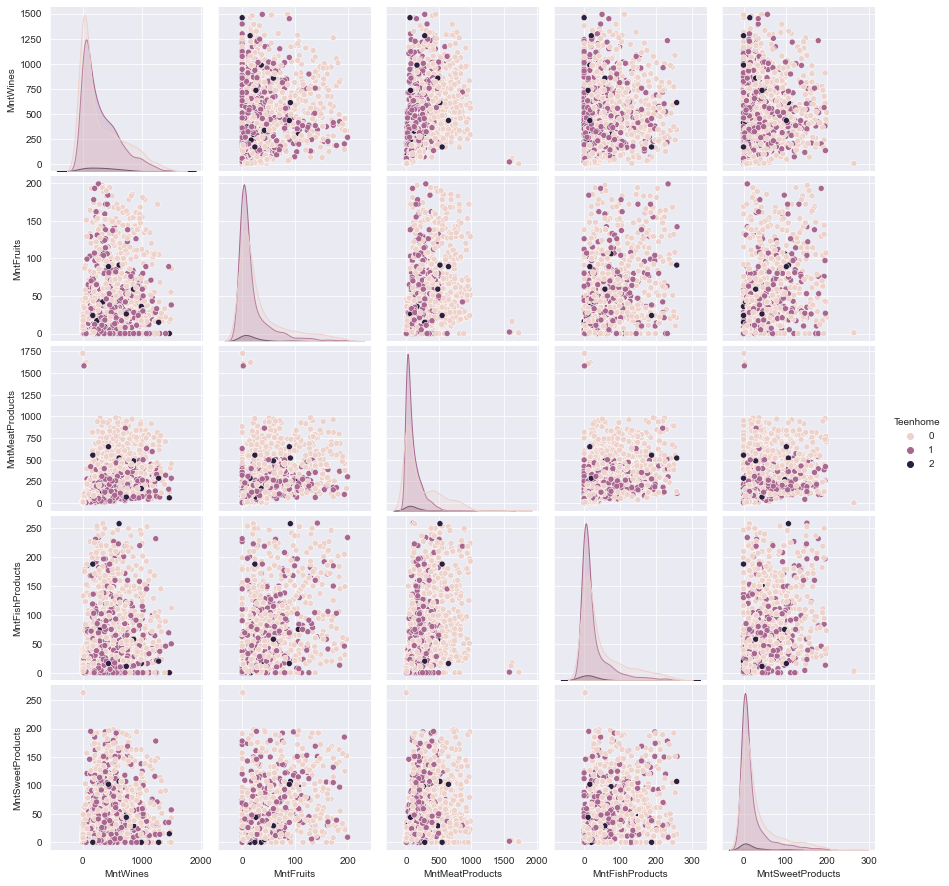

In [19]:
sns.pairplot(df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'Teenhome']], hue='Teenhome')

Text(0.5, 1.0, 'Histogram of Purchases Made with Discount')

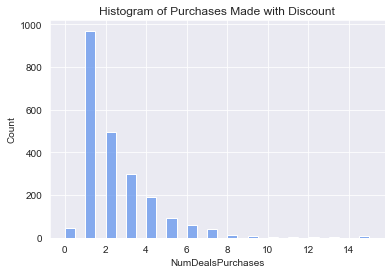

In [20]:
sns.histplot(df['NumDealsPurchases'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Purchases Made with Discount')

Text(0.5, 1.0, 'Histogram of Purchases Made using Catalogue')

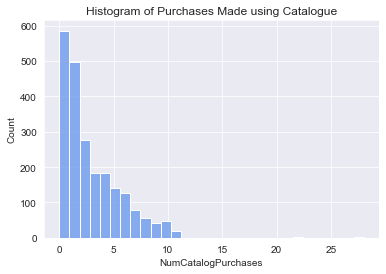

In [21]:
sns.histplot(df['NumCatalogPurchases'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Purchases Made using Catalogue')

Text(0.5, 1.0, 'Histogram of Purchases Made in Store')

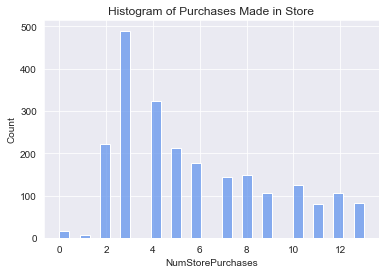

In [22]:
sns.histplot(df['NumStorePurchases'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Purchases Made in Store')

Text(0.5, 1.0, 'Histogram of Purchases Made through Web Site')

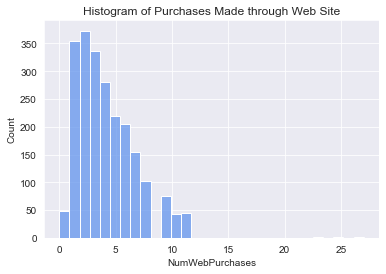

In [23]:
sns.histplot(df['NumWebPurchases'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Purchases Made through Web Site')

Text(0.5, 1.0, 'Histogram of Web Visits in Last Month')

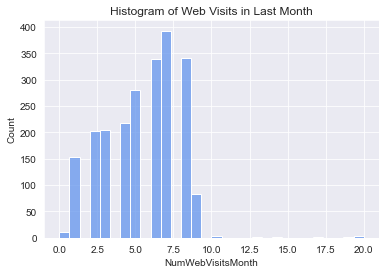

In [24]:
sns.histplot(df['NumWebVisitsMonth'], kde=False, bins=30, color=bar_color)
plt.title('Histogram of Web Visits in Last Month')

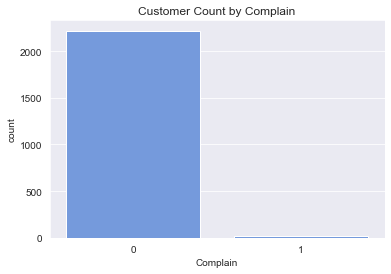

In [25]:
plot_counts('Complain', df)

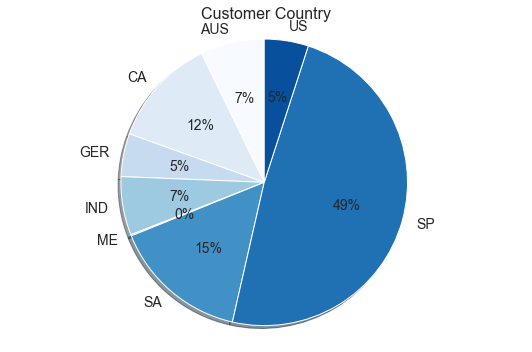

In [26]:
pieChartBreakdown(df, 'Country', title='Customer Country')

### Campaign Success

Overall, campaign 4 is most successful by a small amount. Campaign 2 is not very successful compared to the others.

In [37]:
n_customers = len(df.index)
campaigns = ['AcceptedCmp' + str(i) for i in range(1, 6)]
campaign_success = {}

for key in campaigns:
    accepted = df[key].sum()
    campaign_success[key] = {'tot': n_customers, 'accepted': accepted, 'accepted_rate': accepted / n_customers}
    
print('Accepted Rates by Campaign:')
for key in campaigns:
    print('{0}: {1:.2f}%.'.format(key, 100 * campaign_success[key]['accepted_rate']))
    

Accepted Rates by Campaign:
AcceptedCmp1: 6.43%.
AcceptedCmp2: 1.34%.
AcceptedCmp3: 7.28%.
AcceptedCmp4: 7.46%.
AcceptedCmp5: 7.28%.


## Data Preparation

#### Income
Convert from a string in format $XX,XXX.XX to a number.

In [27]:
def income_to_float(s):
    """Convert an income string to a float number."""
    if isinstance(s, str):
        # remove whitespace and dollar sign
        s = s.strip()[1:]
    
        # split decimal point
        cents = float(s.split('.')[1]) / 100.0
        dollars = sum([float(n) * 1000**i for (i, n) in enumerate(s.split('.')[0].split(',')[::-1])])
    
        return dollars + cents
    else:
        return np.nan

# example:
income_to_float(' $84,124.86 ')

84124.86

In [28]:
df['Income'] = df[' Income '].apply(income_to_float)
df[['Income', ' Income ']].head()

,Income,Income
0,84835.0,"$84,835.00"
1,57091.0,"$57,091.00"
2,67267.0,"$67,267.00"
3,32474.0,"$32,474.00"
4,21474.0,"$21,474.00"


Text(0.5, 1.0, 'Histogram of Customer Income')

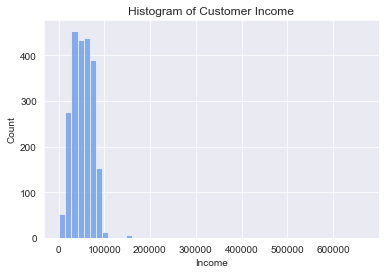

In [29]:
sns.histplot(df['Income'], kde=False, bins=50, color=bar_color)
plt.title('Histogram of Customer Income')

In [30]:
df['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

#### Data cleaning: in the 24 rows where Income is missing, replace it with the median income.
- This is only about 1% of the data, so the impact of making this correction is small.
- Fill with the median instead of the mean because there are some large outlier incomes.

In [45]:
df.loc[np.isnan(df['Income']), 'Income'] = df['Income'].median()
print(df['Income'].median())

51381.5


#### Dt_Customer
Convert from string in format MM/DD/YY to a date.

In [31]:
df['Enrollment Date'] = pd.to_datetime(df['Dt_Customer']).apply(lambda d: d.date())
df[['Dt_Customer', 'Enrollment Date']].head()

,Dt_Customer,Enrollment Date
0,6/16/14,2014-06-16
1,6/15/14,2014-06-15
2,5/13/14,2014-05-13
3,5/11/14,2014-05-11
4,4/8/14,2014-04-08


#### Year_Birth
There are some Year_Birth entries that imply the customer is over 110 years old. These are probably data entry errors. Replace these outliers with 1940, which is the bottom of the Year_Birth distribution when these 110 year-old points are excluded.

In [32]:
df[['Year_Birth']].sort_values('Year_Birth').head()

,Year_Birth
513,1893
827,1899
2233,1900
2171,1940
1740,1941


In [33]:
df.loc[df['Year_Birth'] < 1940, 'Year_Birth'] = 1940

### Encode columns with string values as numbers

In [34]:
str_cols = ['Education', 'Marital_Status', 'Country']

str_col_values = {}

for c in str_cols:
    str_col_values[c] = list(df.groupby([c]).count().index)

In [184]:
str_col_values

{'Education': ['2n Cycle', 'Basic', 'Graduation', 'Master', 'PhD'],
 'Marital_Status': ['Absurd',
  'Alone',
  'Divorced',
  'Married',
  'Single',
  'Together',
  'Widow',
  'YOLO'],
 'Country': ['AUS', 'CA', 'GER', 'IND', 'ME', 'SA', 'SP', 'US']}

### Use 0/1 encoding for string columns

In [185]:
df = pd.get_dummies(df, columns=str_cols)

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2240 non-null   int64  
 1   Year_Birth               2240 non-null   int64  
 2    Income                  2216 non-null   object 
 3   Kidhome                  2240 non-null   int64  
 4   Teenhome                 2240 non-null   int64  
 5   Dt_Customer              2240 non-null   object 
 6   Recency                  2240 non-null   int64  
 7   MntWines                 2240 non-null   int64  
 8   MntFruits                2240 non-null   int64  
 9   MntMeatProducts          2240 non-null   int64  
 10  MntFishProducts          2240 non-null   int64  
 11  MntSweetProducts         2240 non-null   int64  
 12  MntGoldProds             2240 non-null   int64  
 13  NumDealsPurchases        2240 non-null   int64  
 14  NumWebPurchases         

### Correlation
Split up columns into similar groups and look at correlation with ad acceptance.

<AxesSubplot:>

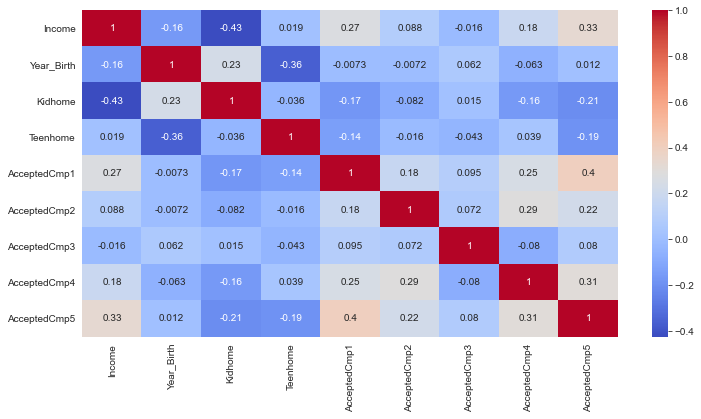

In [187]:
plt.figure(figsize=[12,6])
sns.heatmap(data=df[['Income', 'Year_Birth', 'Kidhome', 'Teenhome'] + campaigns].corr(), annot=True, cmap='coolwarm')


- The amount variables are fairly correlated among themselves. 
- Wine amount has 0.47 correlcation with ad 5 and 0.37 with ad 4.
- Meat amount has 0.37 with ad 5.

<AxesSubplot:>

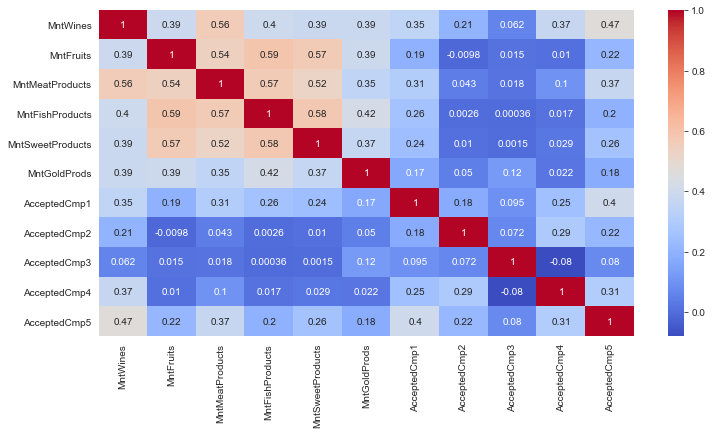

In [188]:
plt.figure(figsize=[12,6])
sns.heatmap(data=df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'] + campaigns].corr(), annot=True, cmap='coolwarm')


Look at just Wine and Meat spending and ad campaign 5, where correlations are strongest. Customers who spent very high amounts on wine or meat were more likely to accept ad campaign 5. This suggests that simply high spending is related to acceptance rate.

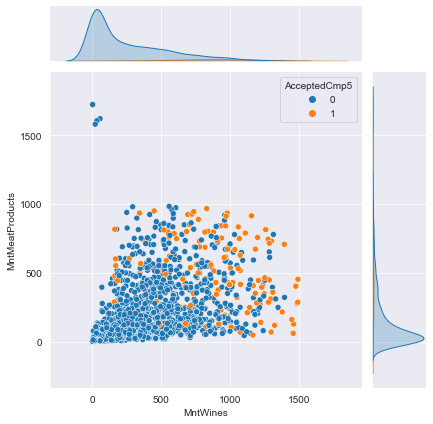

In [35]:
sns.jointplot(x='MntWines', y='MntMeatProducts', data=df, hue='AcceptedCmp5')
plt.xlabel('Amount Spend on Wine in Last 2 Years')

plt.show()

- Catalog purchases has 0.31 correlation with ad 1 and and 0.32 correlation with ad 5.

<AxesSubplot:>

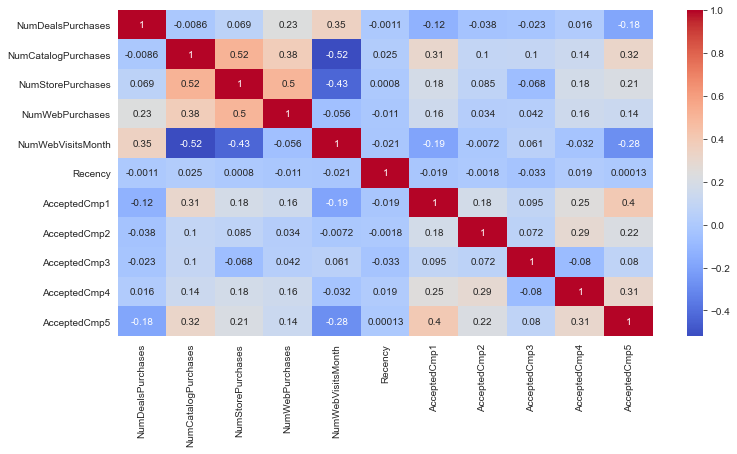

In [38]:
plt.figure(figsize=[12,6])
sns.heatmap(data=df[['NumDealsPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebPurchases', 'NumWebVisitsMonth', 'Recency'] + campaigns].corr(), annot=True, cmap='coolwarm')


### Added columns

Take sum of amount spent columns to get an idea of total amount spent in last 2 years.

In [39]:
df['SumMntSpent'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']


<AxesSubplot:>

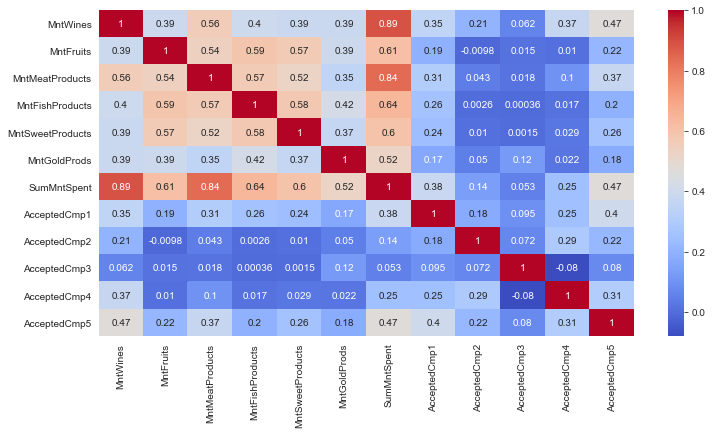

In [192]:
plt.figure(figsize=[12,6])
sns.heatmap(data=df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'SumMntSpent'] + campaigns].corr(), annot=True, cmap='coolwarm')


### Ad 1 has more success at high Income levels

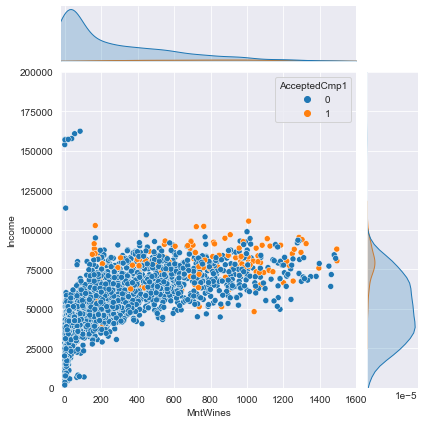

In [193]:
sns.jointplot(x='MntWines', y='Income', data=df, hue='AcceptedCmp1', xlim=(-20,1600), ylim=(-20, 200000))
plt.show()

### Most ad 5 success came at high range of income and spending distribution

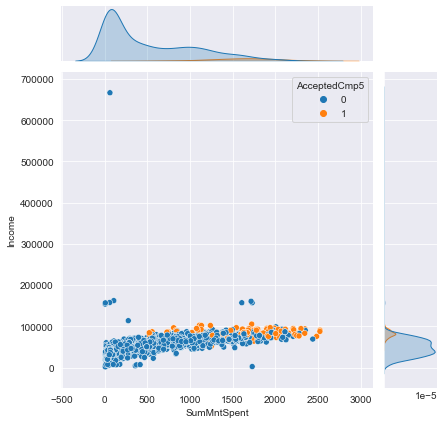

In [40]:
sns.jointplot(x='SumMntSpent', y='Income', data=df, hue='AcceptedCmp5')

## Business Problem
Suppose that we want to use the collected data to design an algorithm for ad targeting. When we show an ad to a customer for the first time (i.e., an out of sample customer), which of these ad campaigns should we show them? 
- Show the ad that maximizes the probability that the customer accepts.
- Assume that for each customer we have the same data fields available (except the Acceptance/Response variables).
- We can use a statistical model to predict the probability that a given customer accepts each ad, then we select the ad with the highest acceptance probability.
- Some possible models we can use to predict the probability of acceptance:
    1. Logistic Regression
    2. Naive Bayes
    3. Random Forest
- As a way to test performance we can use a train/test split and compare the model results to simply showing every customer the same ad.

## Modeling
- For of the ads, 1 to 5, we create a binary classification model for accepting the ad.
    - x variables: the numerical feature columns 
    - y variable: 'AcceptedCmp_' for the ad
- For a given customer, run each of the 5 classification models, and show the customer the ad with the highest prediction probability.
    - The 5 ad acceptance classification models combine to make one ad selection algorithm.

- We try this approach using 3 kinds of models for binary classification:
    1. Logistic Regression
    2. Naive Bayes
    3. Random Forest
- In total we make 15 models, one for each of the 5 ads and 3 model types.

### Features
Use each of the numerical columns for the prediction models.

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       2240 non-null   int64  
 1   Year_Birth               2240 non-null   int64  
 2    Income                  2216 non-null   object 
 3   Kidhome                  2240 non-null   int64  
 4   Teenhome                 2240 non-null   int64  
 5   Dt_Customer              2240 non-null   object 
 6   Recency                  2240 non-null   int64  
 7   MntWines                 2240 non-null   int64  
 8   MntFruits                2240 non-null   int64  
 9   MntMeatProducts          2240 non-null   int64  
 10  MntFishProducts          2240 non-null   int64  
 11  MntSweetProducts         2240 non-null   int64  
 12  MntGoldProds             2240 non-null   int64  
 13  NumDealsPurchases        2240 non-null   int64  
 14  NumWebPurchases         

/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
import sklearn
sklearn.__version__

'0.24.2'

### Put Income into bins so we can treat it as a discrete variable.

In [46]:
from sklearn.preprocessing import KBinsDiscretizer

binner = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='quantile')

b = binner.fit_transform(np.array(df['Income']).reshape(-1,1))
df['Binned_Income'] = pd.Series(list(b))

In [47]:
feature_list = [
    'Year_Birth',
    'Kidhome',
    'Teenhome',
    'Recency',
    'MntWines',
    'MntFruits',
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts',
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    'Complain',
    'Binned_Income'
]

#for c in str_cols: 
#    feature_list += [c + '_' + v for v in str_col_values[c]]

In [48]:
feature_list

['Year_Birth',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'Complain',
 'Binned_Income']

### Logistic Regression model for ad campaign acceptance probability

In [49]:
from sklearn.linear_model import LogisticRegression  

### Naive Bayes model for ad campaign acceptance probability
Use Categorical naive Bayes model to fit the marginal distributions of the feature variables. Gaussian assumption does not seem reasonable since the feature variables do not appear to be Gaussian (histograms above do not resemble bell curves).

In [50]:
from sklearn.naive_bayes import CategoricalNB

### Random Forest model for ad campaign acceptance probability

In [51]:
from sklearn.ensemble import RandomForestClassifier

### Train the models
- Randomly divide the data into a train/test split so we can evaluate the models on 'new' customers from the test set.
- Use 80% of the data in the training set, 20% in the test set.

In [52]:
training_data_size = 0.80
seed = 2

total_rows = len(df.index)
num_training_samples = int(total_rows * training_data_size)
num_test_samples = total_rows - num_training_samples

print('Choosing random sample of {} rows as training data.'.format(num_training_samples))
df_train = df.sample(num_training_samples, random_state=seed)

test_index = list(set(df.index).difference(df_train.index))

Choosing random sample of 1792 rows as training data.


### Define x and y variables for training models.
- x: numerical columns in training data
- y: AcceptCmp column in training data for this ad
- Each ad has a different y.

In [53]:
x_train = np.array(df_train[feature_list])

# use each campaign as a different response variable
campaigns = ['AcceptedCmp' + str(i) for i in range(1, 6)]
y_train = {c: np.array(df_train[c]) for c in campaigns}

### Fit models

Loop through campaigns, fitting the LogisticRegression, NaiveBayes and RandomForest models for each ad as the response variable. Save the fitted models in a dictionary for later use.

In [54]:
logistic_models = {}
nb_models = {}
random_forest_models = {}

for c in campaigns:
    
    logistic_generator = LogisticRegression(solver='liblinear')
    naive_bayes_generator = CategoricalNB()
    random_forest_generator = RandomForestClassifier(max_depth=6, random_state=seed)
    
    # fit the models
    logistic_models[c] = logistic_generator.fit(x_train, y_train[c])
    nb_models[c] = naive_bayes_generator.fit(x_train, y_train[c])
    random_forest_models[c] = random_forest_generator.fit(x_train, y_train[c])

### Feature Importance
- Feature importane in Random Forest models for each ad

In [55]:
for c in campaigns:
    fs = sorted(zip(feature_list, random_forest_models[c].feature_importances_), key=lambda x: -x[1])
    print(c + ':')
    for f in fs[:3]:
        print('{}: {:.2f}'.format(f[0], f[1]))
    print(' ')

AcceptedCmp1:
Binned_Income: 0.15
MntWines: 0.14
MntMeatProducts: 0.12
 
AcceptedCmp2:
MntWines: 0.23
MntMeatProducts: 0.13
Recency: 0.10
 
AcceptedCmp3:
MntGoldProds: 0.13
NumStorePurchases: 0.11
MntWines: 0.08
 
AcceptedCmp4:
MntWines: 0.23
MntMeatProducts: 0.09
Binned_Income: 0.08
 
AcceptedCmp5:
Binned_Income: 0.25
MntWines: 0.20
MntMeatProducts: 0.09
 


### Evaluating individual models

- For each ad we have 3 models that predict ad acceptance.
- Compare the prediction accuracy between each models for each ad.
- Look at the confusion matrix and accuracy score (correct predictions / total predictions).

#### Confusion Matrix:

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [57]:
for c in campaigns:
    print('\n' + '-'*30)
    print('{}:'.format(c))

    print('\tLogistic Accuracy: {:.2f}%'.format(100*accuracy_score(y_train[c], logistic_models[c].predict(x_train))))
    print(confusion_matrix(y_train[c], logistic_models[c].predict(x_train)))
        
    print('\tBayes Accuracy: {:.2f}%'.format(100*accuracy_score(y_train[c], nb_models[c].predict(x_train))))
    print(confusion_matrix(y_train[c], nb_models[c].predict(x_train)))
    
    print('\tRandom Forest Accuracy: {:.2f}%'.format(100*accuracy_score(y_train[c], random_forest_models[c].predict(x_train))))
    print(confusion_matrix(y_train[c], random_forest_models[c].predict(x_train)))


------------------------------
AcceptedCmp1:
	Logistic Accuracy: 94.20%
[[1674    8]
 [  96   14]]
	Bayes Accuracy: 94.31%
[[1600   82]
 [  20   90]]
	Random Forest Accuracy: 96.04%
[[1682    0]
 [  71   39]]

------------------------------
AcceptedCmp2:
	Logistic Accuracy: 98.88%
[[1772    0]
 [  20    0]]
	Bayes Accuracy: 99.11%
[[1771    1]
 [  15    5]]
	Random Forest Accuracy: 99.55%
[[1772    0]
 [   8   12]]

------------------------------
AcceptedCmp3:
	Logistic Accuracy: 92.58%
[[1654    9]
 [ 124    5]]
	Bayes Accuracy: 94.81%
[[1663    0]
 [  93   36]]
	Random Forest Accuracy: 93.53%
[[1663    0]
 [ 116   13]]

------------------------------
AcceptedCmp4:
	Logistic Accuracy: 93.69%
[[1659   11]
 [ 102   20]]
	Bayes Accuracy: 95.26%
[[1653   17]
 [  68   54]]
	Random Forest Accuracy: 94.98%
[[1670    0]
 [  90   32]]

------------------------------
AcceptedCmp5:
	Logistic Accuracy: 95.31%
[[1635   22]
 [  62   73]]
	Bayes Accuracy: 92.30%
[[1534  123]
 [  15  120]]
	Random F

#### Observations:
- Random Forest models have highest accuracy score for ads 1, 2, 4, 5
- Bayes model has highest accuracy for ad 3.
- Bayes models tend to predict more 1s than the other two types.
- Since the Random Forest models for individual ads tended to have the highest accuracy, we can expect that the ad selection algorithm based on the Random Forest models might be the best.

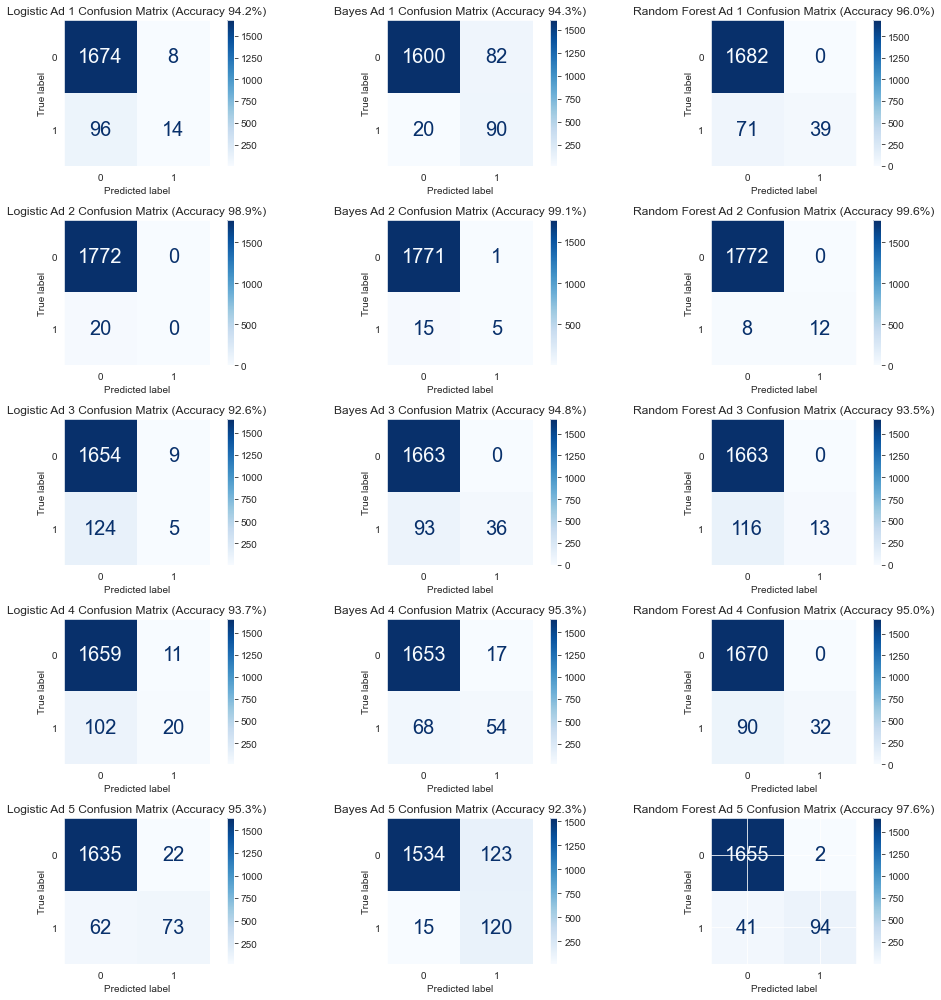

In [58]:
models = {'Logistic': logistic_models, 'Bayes': nb_models, 'Random Forest': random_forest_models}

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(14, 14))

for ad in range(1, 6):
    i = 0
    c = 'AcceptedCmp' + str(ad)
    
    for model_name, model_dict in models.items():
        
        accuracy_pct = 100.0 * accuracy_score(y_train[c], model_dict[c].predict(x_train))
        
        # Turn off grid lines
        ax[ad-1][i].grid(False)
        
        f = plot_confusion_matrix(model_dict[c], x_train, y_train[c], cmap=plt.cm.Blues, ax=ax[ad-1][i])
        f.ax_.set_title(model_name + ' Ad ' + str(ad) + ' Confusion Matrix (Accuracy {:.1f}%)'.format(accuracy_pct))
        f.ax_.figsize = (15, 10)
        
        # make fond size bigger
        for labels in f.text_.ravel():
            labels.set_fontsize(20)
        
        i += 1
plt.grid(None)      
plt.tight_layout()
plt.show()

### ROC curves and AUC

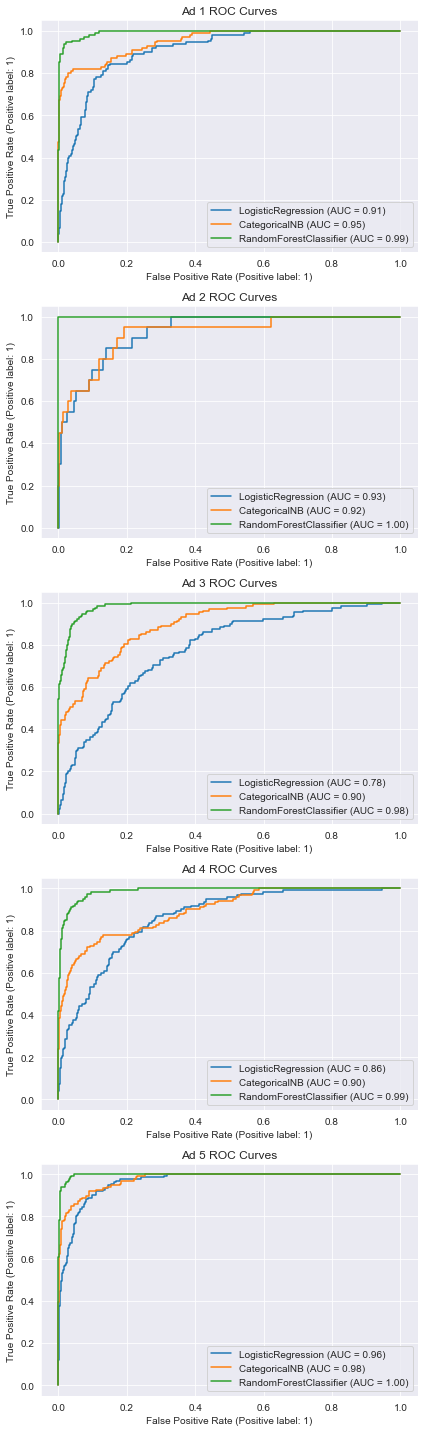

In [59]:
models = {'Logistic': logistic_models, 'Bayes': nb_models, 'Random Forest': random_forest_models}

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(6, 20))

for ad in range(1, 6):
    c = 'AcceptedCmp' + str(ad)
    
    for model_name, model_dict in models.items():
        
        f = plot_roc_curve(model_dict[c], x_train, y_train[c], ax=ax[ad-1])
        f.ax_.set_title('Ad ' + str(ad) + ' ROC Curves')
              
plt.tight_layout()
plt.show()

### K-fold cross-validation
Assess performance of each model class (Logistic Regression, Naive Bayes, Random Forest) with each ad using cross-validation. 
- Use the training data for cross-validation with k=5 folds 
    - Each validation has roughly 360 customers in the test population and 1,440 in the training population.
- Use accuracy and ROC curve AUC to evaluate model performance.
- Take the average accuracy and ROC curve AUC over the 5 folds to assess model performance.

There is an issue with CategoricalNB in the cross-validation.
- If the test data contains a category that isn't in the training data, then the model won't know how to calculate conditional probabilities for the new category. 
- This causes some of the cross-validation tests to fail for CategoricalNB.
- This issue could be a reason to use a different kind of Naive Bayes (instead of categorical): if the model doesn't see every possible category during training, then it won't know how to predict a new category it sees for the first time. 
- For the time being we just hide the failed cross-validation tests for CategoricalNB and take the average score of the successful cross-validation tests.

In [60]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [61]:
import warnings

In [62]:
# folds
folds = 5
splitter = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)

# scoring
scoring = ['accuracy', 'roc_auc']

cross_validations = {}

for c in campaigns:

    # use same model generators
    logistic_generator = LogisticRegression(solver='liblinear')
    naive_bayes_generator = CategoricalNB()
    random_forest_generator = RandomForestClassifier(max_depth=6, random_state=seed)

    # disable warnings
    warnings.filterwarnings('ignore')
    
    # generate cross-validations
    cross_validations['Logistic'] = cross_validate(logistic_generator, x_train, y_train[c], scoring=scoring, cv=splitter, return_estimator=True)
    cross_validations['Bayes'] = cross_validate(naive_bayes_generator, x_train, y_train[c], scoring=scoring, cv=splitter, return_estimator=True)
    cross_validations['Random Forest'] = cross_validate(random_forest_generator, x_train, y_train[c], scoring=scoring, cv=splitter, return_estimator=True)

    # gather results
    for m in ['Logistic', 'Bayes', 'Random Forest']:
        cross_validations[m]['avg_accuracy'] = np.nanmean(cross_validations[m]['test_accuracy'])
        cross_validations[m]['avg_ROC_AUC'] = np.nanmean(cross_validations[m]['test_roc_auc'])
    
    # Print Results
    title = 'Ad {} Cross-validation Results:'.format(c)
    print(title + '\n' + '-'*len(title))
    
    for m in ['Logistic', 'Bayes', 'Random Forest']:
        print('{:15} average accuracy = {:.2f}%, . . . . . average ROC AUC = {:.2f}%'.format(m, 100*cross_validations[m]['avg_accuracy'], 100*cross_validations[m]['avg_ROC_AUC']))

    print('\n\n')
        
# re-enable warnings
warnings.resetwarnings()

Ad AcceptedCmp1 Cross-validation Results:
-----------------------------------------
Logistic        average accuracy = 93.69%, . . . . . average ROC AUC = 88.86%
Bayes           average accuracy = 88.30%, . . . . . average ROC AUC = 84.66%
Random Forest   average accuracy = 94.25%, . . . . . average ROC AUC = 90.43%



Ad AcceptedCmp2 Cross-validation Results:
-----------------------------------------
Logistic        average accuracy = 98.77%, . . . . . average ROC AUC = 82.97%
Bayes           average accuracy = 98.61%, . . . . . average ROC AUC = 58.66%
Random Forest   average accuracy = 99.00%, . . . . . average ROC AUC = 86.87%



Ad AcceptedCmp3 Cross-validation Results:
-----------------------------------------
Logistic        average accuracy = 92.63%, . . . . . average ROC AUC = 74.28%
Bayes           average accuracy = 92.74%, . . . . . average ROC AUC = 66.45%
Random Forest   average accuracy = 92.80%, . . . . . average ROC AUC = 83.09%



Ad AcceptedCmp4 Cross-validation Resu

### Conclusions:
- For every ad, the average ROC AUC in the cross-validation tests have the same ranking:
    1. Random Forest
    2. Logistic Regression
    3. Naive Bayes
- For every ad, the Random Forest model had the highest average accuracy score in the cross-validation tests.
- The Logistic Regression model had the second highest average accuracy score in the cros-validation tests for every ad except ad 3, where it was only slightly below Naive Bayes.
- CategoricalNB predictions can fail when model does not see every possible category during training.

Demo of failed cross-validation tests for CategoricalNB:

In [213]:
c = campaigns[0]
ans = cross_validate(CategoricalNB(), x_train, y_train[c], cv=5, scoring=scoring)
print(ans)

{'fit_time': array([0.00506496, 0.00552297, 0.00418305, 0.00532675, 0.00351501]), 'score_time': array([0.00602698, 0.00057912, 0.00060296, 0.0007081 , 0.00054598]), 'test_accuracy': array([0.89693593,        nan,        nan,        nan,        nan]), 'test_roc_auc': array([0.87307796,        nan,        nan,        nan,        nan])}


/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/justin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/justin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/justin/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "/Users/justin/opt/anaconda3/lib

## Ad Selection Algorithms

### Pick the ad with highest predicted acceptance probability

#### Example of how ad recommendation works

In [63]:
x = df[feature_list].iloc[1]
pd.Series([logistic_models[c].predict_proba(np.array(x).reshape(1, -1))[0][1] for c in campaigns])

/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    0.049550
1    0.019525
2    0.079674
3    0.085463
4    0.008673
dtype: float64

In [64]:
def pick_ad(model_dict, x):
    """Return the ad with highest predicted acceptance probability among the models."""
    max_prob_index = pd.Series([model_dict[c].predict_proba(np.array(x).reshape(1, -1))[0][1] for c in campaigns]).argmax()
    return campaigns[max_prob_index]

/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Ads selected for the first 50 rows of customer data using each type of model:

In [216]:
# example ads picked for the first 50 rows
for i in range(50):
    xi = df[feature_list].iloc[i]
    print('{:4}. logistic: {}\t bayes: {}\t random forest: {}'.format(i, pick_ad(logistic_models, xi), pick_ad(nb_models, xi), pick_ad(random_forest_models, xi)))

   0. logistic: AcceptedCmp5	 bayes: AcceptedCmp5	 random forest: AcceptedCmp5
   1. logistic: AcceptedCmp4	 bayes: AcceptedCmp3	 random forest: AcceptedCmp2
   2. logistic: AcceptedCmp4	 bayes: AcceptedCmp4	 random forest: AcceptedCmp3
   3. logistic: AcceptedCmp3	 bayes: AcceptedCmp3	 random forest: AcceptedCmp3
   4. logistic: AcceptedCmp3	 bayes: AcceptedCmp3	 random forest: AcceptedCmp3
   5. logistic: AcceptedCmp1	 bayes: AcceptedCmp1	 random forest: AcceptedCmp1
   6. logistic: AcceptedCmp3	 bayes: AcceptedCmp3	 random forest: AcceptedCmp3
   7. logistic: AcceptedCmp3	 bayes: AcceptedCmp3	 random forest: AcceptedCmp4
   8. logistic: AcceptedCmp4	 bayes: AcceptedCmp4	 random forest: AcceptedCmp1
   9. logistic: AcceptedCmp4	 bayes: AcceptedCmp4	 random forest: AcceptedCmp1
  10. logistic: AcceptedCmp5	 bayes: AcceptedCmp5	 random forest: AcceptedCmp5
  11. logistic: AcceptedCmp4	 bayes: AcceptedCmp3	 random forest: AcceptedCmp4
  12. logistic: AcceptedCmp1	 bayes: AcceptedCmp5	 r

The 3 ad-picking algorithms based on the model types often recommend the same ad, but not always.

### Map the model ad recommendations as new columns

In [104]:
# Logistic recommendation
df['Logistic_Ad_Rec'] = pd.Series([pick_ad(logistic_models, df[feature_list].iloc[i])[-1] for i in df.index]) 

# Bayes recommendation
df['NB_Ad_Rec'] = pd.Series([pick_ad(nb_models, df[feature_list].iloc[i])[-1] for i in df.index]) 

# Random forest recommendation
df['RF_Ad_Rec'] = pd.Series([pick_ad(random_forest_models, df[feature_list].iloc[i])[-1] for i in df.index]) 

/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Evaluating Ad Selection Algorithms
Add columns showing if the ad recommended by the model would have been accepted by the customer.

In [105]:
df['Accepted_Logistic'] = pd.Series([df.iloc[i]['AcceptedCmp' + df['Logistic_Ad_Rec'].iloc[i]] for i in df.index])

df['Accepted_NB'] = pd.Series([df.iloc[i]['AcceptedCmp' + df['NB_Ad_Rec'].iloc[i]] for i in df.index])

df['Accepted_RF'] = pd.Series([df.iloc[i]['AcceptedCmp' + df['RF_Ad_Rec'].iloc[i]] for i in df.index])

/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
df[campaigns + ['Logistic_Ad_Rec', 'NB_Ad_Rec', 'RF_Ad_Rec', 'Accepted_Logistic', 'Accepted_NB', 'Accepted_RF']].head(10)


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Logistic_Ad_Rec,NB_Ad_Rec,RF_Ad_Rec,Accepted_Logistic,Accepted_NB,Accepted_RF
0,0,0,0,0,0,5,5,5,0,0,0
1,0,1,0,0,0,4,3,2,0,0,1
2,0,0,0,0,0,4,4,3,0,0,0
3,0,0,0,0,0,3,3,3,0,0,0
4,0,0,1,0,0,3,3,3,1,1,1
5,0,0,0,0,0,1,1,1,0,0,0
6,0,0,1,0,0,3,3,3,1,1,1
7,0,0,0,0,0,3,3,4,0,0,0
8,0,0,0,0,0,4,4,1,0,0,0
9,0,0,0,0,0,4,4,1,0,0,0


### Out-of-sample success
Test ad-picking success on the customers that were left out of the training data. For comparison, show the acceptance rate of each ad individually on the set of training customers.

- Model-based ad-picking algorithms have much better acceptance rates than any single ad (about 2 times higher).
- The ad-picking algorithm based on random forest models has the highest acceptance rate.

In [107]:
df_test = df.loc[test_index]

n_customers = len(df_test.index)

ad_picking_methods = ['AcceptedCmp' + str(i) for i in range(1, 6)] + ['Accepted_Logistic', 'Accepted_NB', 'Accepted_RF']
ad_picking_success = {}

for key in ad_picking_methods:
    accepted = df_test[key].sum()
    ad_picking_success[key] = {'tot': n_customers, 'accepted': accepted, 'accepted_rate': accepted / n_customers}
    
print('Accepted Rates by Campaign:')
for key in ad_picking_methods:
    print('{0}: {1:.2f}%.'.format(key, 100 * ad_picking_success[key]['accepted_rate']))

Accepted Rates by Campaign:
AcceptedCmp1: 7.59%.
AcceptedCmp2: 2.23%.
AcceptedCmp3: 7.59%.
AcceptedCmp4: 10.04%.
AcceptedCmp5: 6.25%.
Accepted_Logistic: 17.19%.
Accepted_NB: 15.40%.
Accepted_RF: 17.41%.


/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Miss-rate
Similar to false positives, how often did the algorithms recommend an ad that wasn't accepted when the customer would have accepted a different ad?

In [235]:
df_test['Accepted_Some_Ad'] = df_test['AcceptedCmp1'] + df_test['AcceptedCmp2'] + df_test['AcceptedCmp3'] + df_test['AcceptedCmp4'] + df_test['AcceptedCmp5']

accepted_some_ad = len(df_test[df_test['Accepted_Some_Ad'] > 0].index)
ad_picking_failure = {}

for key in ad_picking_methods:
    missed = len(df_test[(df_test[key] == 0) & (df_test['Accepted_Some_Ad'] > 0)].index)
    ad_picking_failure[key] = {'tot': accepted_some_ad, 'missed': missed, 'miss_rate': missed/accepted_some_ad}
    
print('Miss Rates by Campaign:')
for key in ad_picking_methods:
    print('{0}: {1:.2f}%.'.format(key, 100 * ad_picking_failure[key]['miss_rate']))

Miss Rates by Campaign:
AcceptedCmp1: 65.31%.
AcceptedCmp2: 89.80%.
AcceptedCmp3: 65.31%.
AcceptedCmp4: 54.08%.
AcceptedCmp5: 71.43%.
Accepted_Logistic: 21.43%.
Accepted_NB: 29.59%.
Accepted_RF: 20.41%.


/Users/justin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Conclusions:
- Using the ad campaign data we can create algorithms to choose the most effective ad to display to a customer. 
- We show each customer the ad that maximizes the probability that they accept, according to a statistical model.
- This business can achieve a meaningful improvement in marketing ad campaign success by using a statistical model for ad selection.
- New customers would have significantly higher acceptance rates using one of our statistical models compared to  any individual ad in the campaign.
- Our Random Forest model performed the best on the test data, with an acceptance rate about double the acceptance rate the best performing individual ad (campaign 3).

### In-sample success
Looking over test, using one of our ad-selecting algorithms to pick the ad would have a better acceptance rate than fixing a single ad to show everyone.
- Random Forest still had best performance on training data.
- Logistic regression performance was lower on training data. 
- When we look at the training data, our ad-picking algorthims perform much better than choosing any single ad to show every customer.

In [108]:
df_train = df.loc[df_train.index]

n_customers = len(df.index)
in_sample_success = {}

for key in ad_picking_methods:
    accepted = df_train[key].sum()
    in_sample_success[key] = {'tot': n_customers, 'accepted': accepted, 'accepted_rate': accepted / n_customers}
    
print('Accepted Rates by Campaign:')
for key in ad_picking_methods:
    print('{0}: {1:.2f}%.'.format(key, 100 * in_sample_success[key]['accepted_rate']))

Accepted Rates by Campaign:
AcceptedCmp1: 4.91%.
AcceptedCmp2: 0.89%.
AcceptedCmp3: 5.76%.
AcceptedCmp4: 5.45%.
AcceptedCmp5: 6.03%.
Accepted_Logistic: 12.41%.
Accepted_NB: 15.36%.
Accepted_RF: 15.89%.
